In [30]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

In [31]:
# Cargar el dataset combinado limpio
data = pd.read_csv('../data/processed/olist_combined_initial.csv')

payments = pd.read_csv('../data/raw/olist_order_payments_dataset.csv')

data = data.merge(payments, on='order_id', how='left')

In [32]:

# Convertir fechas
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])

# Última fecha de compra registrada
last_date = data['order_purchase_timestamp'].max()
print("Última fecha del dataset:", last_date)

# Definir periodo de inactividad (por ejemplo, 90 días)
threshold_days = 90

# Calcular última compra por cliente
last_purchase = data.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
last_purchase['days_since_last_purchase'] = (last_date - last_purchase['order_purchase_timestamp']).dt.days

# Crear variable objetivo (1 = desertor, 0 = activo)
last_purchase['churned'] = (last_purchase['days_since_last_purchase'] > threshold_days).astype(int)

last_purchase.head()

Última fecha del dataset: 2018-10-17 17:30:18


,customer_unique_id,order_purchase_timestamp,days_since_last_purchase,churned
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,1
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,1


In [33]:
# Total de pedidos
orders_per_customer = data.groupby('customer_unique_id')['order_id'].nunique().reset_index()
orders_per_customer.columns = ['customer_unique_id', 'total_orders']

# Total gastado
spent_per_customer = data.groupby('customer_unique_id')['payment_value'].sum().reset_index()
spent_per_customer.columns = ['customer_unique_id', 'total_spent']

# Promedio del valor de compra
avg_order_value = spent_per_customer.copy()
avg_order_value['avg_order_value'] = avg_order_value['total_spent'] / orders_per_customer['total_orders']

# Promedio del puntaje de reseñas
avg_review_score = data.groupby('customer_unique_id')['review_score'].mean().reset_index()
avg_review_score.columns = ['customer_unique_id', 'avg_review_score']

# Unir todas las features
features = last_purchase.merge(orders_per_customer, on='customer_unique_id', how='left')
features = features.merge(spent_per_customer, on='customer_unique_id', how='left')
features = features.merge(avg_order_value[['customer_unique_id', 'avg_order_value']], on='customer_unique_id', how='left')
features = features.merge(avg_review_score, on='customer_unique_id', how='left')

features.head()

,customer_unique_id,order_purchase_timestamp,days_since_last_purchase,churned,total_orders,total_spent,avg_order_value,avg_review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,160,1,1,141.90,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,163,1,1,27.19,27.19,4.0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,585,1,1,86.22,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,369,1,1,43.62,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,336,1,1,196.89,196.89,5.0


In [34]:
# Variables predictoras y objetivo
X = features[['total_orders', 'total_spent', 'avg_order_value', 'avg_review_score', 'days_since_last_purchase']]
y = features['churned']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Escalar variables numéricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
features.isnull().sum()


customer_unique_id            0
order_purchase_timestamp      0
days_since_last_purchase      0
churned                       0
total_orders                  0
total_spent                   0
avg_order_value               0
avg_review_score            716
dtype: int64

In [36]:
# Ejemplo: reemplazar NaN por 0 en todo el dataset de features
features = features.fillna(0)


In [37]:
features.isnull().sum().sum()


np.int64(0)

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

# Aplicar sobre los datos escalados
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

# Ahora entrenamos los modelos
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(max_depth=5),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=7, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)

In [32]:
best_model = models['Random Forest']
joblib.dump(best_model, 'churn_model.pkl')

['churn_model.pkl']

In [ ]:


# Cargar solo el modelo
model = joblib.load('../models/churn_model.pkl')

# Generar predicciones directamente
preds = model.predict(X_test_scaled)

# Ver resultados
results = X_test.copy()
results['real_churn'] = y_test.values
results['predicted_churn'] = preds

print(results.head(10))


       total_orders  total_spent  avg_order_value  avg_review_score  \
36253             1        73.50            73.50               5.0   
9926              1       148.71           148.71               3.0   
45497             1        39.42            39.42               5.0   
71608             1        28.23            28.23               5.0   
3100              1       116.94           116.94               5.0   
52190             1       279.98           279.98               4.0   
46411             1        49.01            49.01               5.0   
23647             1       473.12           473.12               5.0   
76430             1        83.23            83.23               1.0   
36564             1       150.67           150.67               5.0   

       days_since_last_purchase  real_churn  predicted_churn  
36253                       213           1                1  
9926                        539           1                1  
45497                        


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2899
           1       1.00      1.00      1.00     25930

    accuracy                           1.00     28829
   macro avg       1.00      1.00      1.00     28829
weighted avg       1.00      1.00      1.00     28829



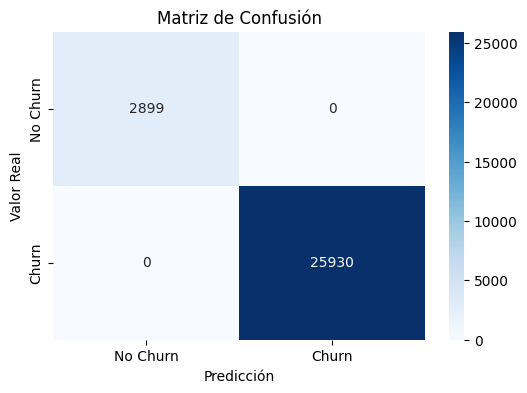

In [44]:


# Métricas de rendimiento
print("\nReporte de Clasificación:")
print(classification_report(y_test, preds))

# Matriz de confusión
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


In [45]:
numeric_features = features.select_dtypes(include=['int64', 'float64'])
correlations = numeric_features.corr()['churned'].sort_values(ascending=False)
print(correlations)


churned                     1.000000
days_since_last_purchase    0.471123
avg_order_value             0.004702
total_spent                 0.002909
total_orders               -0.013655
avg_review_score           -0.044641
Name: churned, dtype: float64


In [55]:
# Calcular proporción de reseñas negativas por cliente
negative_review_ratio = data.groupby('customer_unique_id')['review_score'].apply(lambda x: (x <= 2).mean()).reset_index()
negative_review_ratio.columns = ['customer_unique_id', 'negative_review_ratio']

# Unir con el dataset principal de features
features = features.merge(negative_review_ratio, on='customer_unique_id', how='left')


In [56]:
last_review = data.sort_values('review_creation_date').groupby('customer_unique_id').last()['review_score'].reset_index()
last_review.columns = ['customer_unique_id', 'last_review_score']

features = features.merge(last_review, on='customer_unique_id', how='left')


In [ ]:

# Definir X sin la columna days_since_last_purchase
X = features[['total_orders', 'total_spent', 'avg_order_value',
              'avg_review_score', 'negative_review_ratio',
              'last_review_score']]

y = features['churned']


KeyError: "['negative_review_ratio', 'last_review_score'] not in index"

In [49]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [50]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model.fit(X_train_scaled, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
y_pred = model.predict(X_test_scaled)

print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       1.00      1.00      1.00     17287

    accuracy                           1.00     19220
   macro avg       1.00      1.00      1.00     19220
weighted avg       1.00      1.00      1.00     19220

Matriz de Confusión:
 [[ 1933     0]
 [    0 17287]]


In [54]:
numeric_features = features.select_dtypes(include=['int64', 'float64'])
correlations = numeric_features.corr()['churned'].sort_values(ascending=False)
print(correlations)


churned                     1.000000
days_since_last_purchase    0.471123
negative_review_ratio       0.034640
avg_order_value             0.004702
total_spent                 0.002909
total_orders               -0.013655
last_review_score          -0.044355
avg_review_score           -0.044641
Name: churned, dtype: float64


In [52]:
import joblib

joblib.dump({'model': model, 'scaler': scaler}, '../models/churn_model_v2.pkl')


['../models/churn_model_v2.pkl']